In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


98 12544 128.0 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,ast_ngram_n_7_8,ast_ngram_n_7_6,ast_ngram_n_7_7,ast_ngram_n_7_9,domain_name,real,original_game_name,...,ast_ngram_n_6_6,ast_ngram_n_6_7,ast_ngram_n_6_8,ast_ngram_n_6_9,ast_ngram_n_7_0,ast_ngram_n_7_1,ast_ngram_n_7_2,ast_ngram_n_7_3,ast_ngram_n_7_4,ast_ngram_n_7_5
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,0,0,0,0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,...,1,0,0,0,0,0,1,1,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,1,1,1,0,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,...,0,0,1,1,1,1,0,0,1,1
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,0,0,0,0,many-objects-room-v1,1,614b603d4da88384282967a7-3,...,0,0,0,0,0,0,0,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,1,1,1,0,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,...,1,0,1,1,1,1,1,1,1,1
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,1,1,1,0,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,...,1,0,1,1,1,1,1,1,1,1


In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df

model_path = '../models/cv_fitness_model_2023_02_21.pkl.gz'
data_df = fitness_df

with gzip.open(model_path, 'rb') as f:
    cv_energy_model = pickle.load(f)

feature_columns = [str(c) for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]
for n in range(2, 7):
    feature_columns.remove(f'ast_ngram_n_{n}_score')


## Histogram the weights to get a sense of what we're dealing with

Weights mean: 0.1378, std: 0.5280, bias: 2.6936


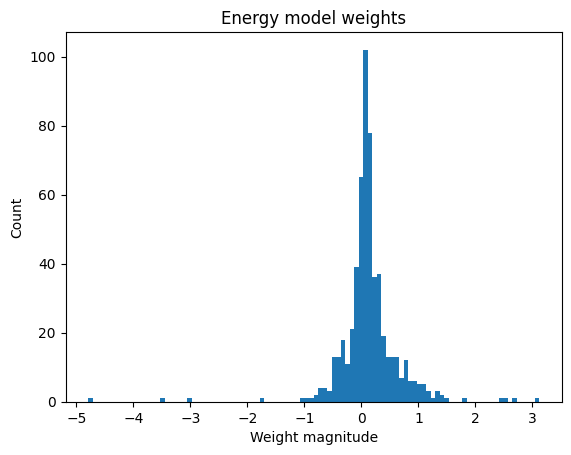

In [6]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=100)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [12]:
for magnitude in (0.01, 0.05, 0.1, 0.5):
    n = torch.sum(torch.abs(weights) < magnitude)
    print(f'Number of weights with magnitude < {magnitude}: {n} ({n / len(weights) * 100:.2f}%)')

Number of weights with magnitude < 0.01: 16 (2.82%)
Number of weights with magnitude < 0.05: 90 (15.87%)
Number of weights with magnitude < 0.1: 174 (30.69%)
Number of weights with magnitude < 0.5: 461 (81.31%)


## Print the top K features most and least predictive of real games

In [13]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games):')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games):')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games):
1. ast_ngram_n_7_score (-4.7903)
2. all_variables_used (-3.5050)
3. variable_not_repeated (-2.9977)
4. all_preferences_used (-1.7284)
5. no_two_number_operations (-1.0204)
6. no_nested_logicals (-0.9310)
7. on_arg_types_furniture_any_object_constraints (-0.8806)
8. compositionality_structure_5 (-0.8339)
9. ast_ngram_n_7_9 (-0.7884)
10. ast_ngram_n_6_7 (-0.7514)
11. ast_ngram_n_6_1 (-0.7430)
12. ast_ngram_n_2_5 (-0.7122)
13. on_arg_types_furniture_large_objects_setup (-0.6810)
14. no_adjacent_same_modal (-0.6746)
15. ast_ngram_n_5_1 (-0.6296)
16. in_arg_types_receptacles_balls_constraints (-0.6164)
17. on_arg_types_furniture_furniture_constraints (-0.5999)
18. on_arg_types_room_features_blocks_setup (-0.5982)
19. compositionality_structure_11 (-0.5564)
20. ast_ngram_n_4_0 (-0.5264)
### Features with largest positive weights (most predictive of fake games):
1. pref_forall_pref_forall_correct_types_incorrect (3.1163)
2. ast_ngram_n_2_4 (2.6890)
3. pref_forall_pref_forall_correct_arity_incorrect (2.4971)
4. redundant_expression_found (2.4617)
5. no_identical_logical_children (1.7971)
6. in_arg_types_other_constraints (1.4651)
7. max_number_variables_types_quantified_variables_2 (1.4199)
8. agent_holds_arg_types_room_features_constraints (1.4179)
9. on_arg_types_other_constraints (1.3496)
10. in_motion_arg_types_room_features_constraints (1.3237)
11. adjacent_arg_types_other_constraints (1.3201)
12. ast_ngram_n_2_0 (1.2895)
13. distance_arg_types_other_setup (1.2073)
14. node_count_terminal_2 (1.1871)
15. touch_arg_types_other_constraints (1.1870)
16. max_quantification_count_setup_1 (1.1347)
17. on_arg_types_other_setup (1.1347)
18. max_depth_scoring_1 (1.1290)
19. length_of_then_modals_3 (1.1106)
20. node_count_scoring_4 (1.0673)

In [57]:
weights[feature_columns.index('in_motion_arg_types_any_object_setup')]

tensor(0.1322)

In [56]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'forall' in c]

[('pref_forall_count_once_per_external_objects_used_correct', tensor(0.1474)),
 ('pref_forall_count_once_per_external_objects_used_incorrect',
  tensor(0.4393)),
 ('pref_forall_external_forall_used_correct', tensor(0.0165)),
 ('pref_forall_external_forall_used_incorrect', tensor(0.8013)),
 ('pref_forall_pref_forall_correct_arity_correct', tensor(-0.3947)),
 ('pref_forall_pref_forall_correct_arity_incorrect', tensor(2.4971)),
 ('pref_forall_pref_forall_correct_types_correct', tensor(-0.4653)),
 ('pref_forall_pref_forall_correct_types_incorrect', tensor(3.1163))]

In [14]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'max_number_variables_types_quantified' in c]

[('max_number_variables_types_quantified_types_1', tensor(0.7250)),
 ('max_number_variables_types_quantified_types_2', tensor(0.6099)),
 ('max_number_variables_types_quantified_types_3', tensor(0.7575)),
 ('max_number_variables_types_quantified_types_4', tensor(0.2259)),
 ('max_number_variables_types_quantified_types_5', tensor(0.2375)),
 ('max_number_variables_types_quantified_types_6', tensor(-0.0129)),
 ('max_number_variables_types_quantified_types_7', tensor(0.0914)),
 ('max_number_variables_types_quantified_types_8', tensor(-0.0959)),
 ('max_number_variables_types_quantified_variables_1', tensor(0.7538)),
 ('max_number_variables_types_quantified_variables_2', tensor(1.4199)),
 ('max_number_variables_types_quantified_variables_3', tensor(0.1357)),
 ('max_number_variables_types_quantified_variables_4', tensor(0.1262)),
 ('max_number_variables_types_quantified_variables_5', tensor(0.0886)),
 ('max_number_variables_types_quantified_variables_6', tensor(0.3156)),
 ('max_number_variable

In [15]:
data_df.groupby('real')[[c for c in feature_columns if 'max_number_variables_types_quantified' in c]].mean()

,max_number_variables_types_quantified_types_1,max_number_variables_types_quantified_types_2,max_number_variables_types_quantified_types_3,max_number_variables_types_quantified_types_4,max_number_variables_types_quantified_types_5,max_number_variables_types_quantified_types_6,max_number_variables_types_quantified_types_7,max_number_variables_types_quantified_types_8,max_number_variables_types_quantified_variables_1,max_number_variables_types_quantified_variables_2,max_number_variables_types_quantified_variables_3,max_number_variables_types_quantified_variables_4,max_number_variables_types_quantified_variables_5,max_number_variables_types_quantified_variables_6,max_number_variables_types_quantified_variables_7,max_number_variables_types_quantified_variables_8
real,,,,,,,,,,,,,,,,
0,0.624791,0.196628,0.122489,0.023846,0.010712,0.0,0.021534,0.0,0.763632,0.155443,0.004674,0.022082,0.010702,0.032426,0.0,0.011041
1,0.653061,0.183673,0.112245,0.020408,0.010204,0.0,0.020408,0.0,0.785714,0.142857,0.000000,0.020408,0.010204,0.030612,0.0,0.010204


## Plot a histogram of the values for each of the and bottom K features

In [16]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    columns = [c for c in df.columns if c not in NON_FEATURE_COLUMNS]
    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

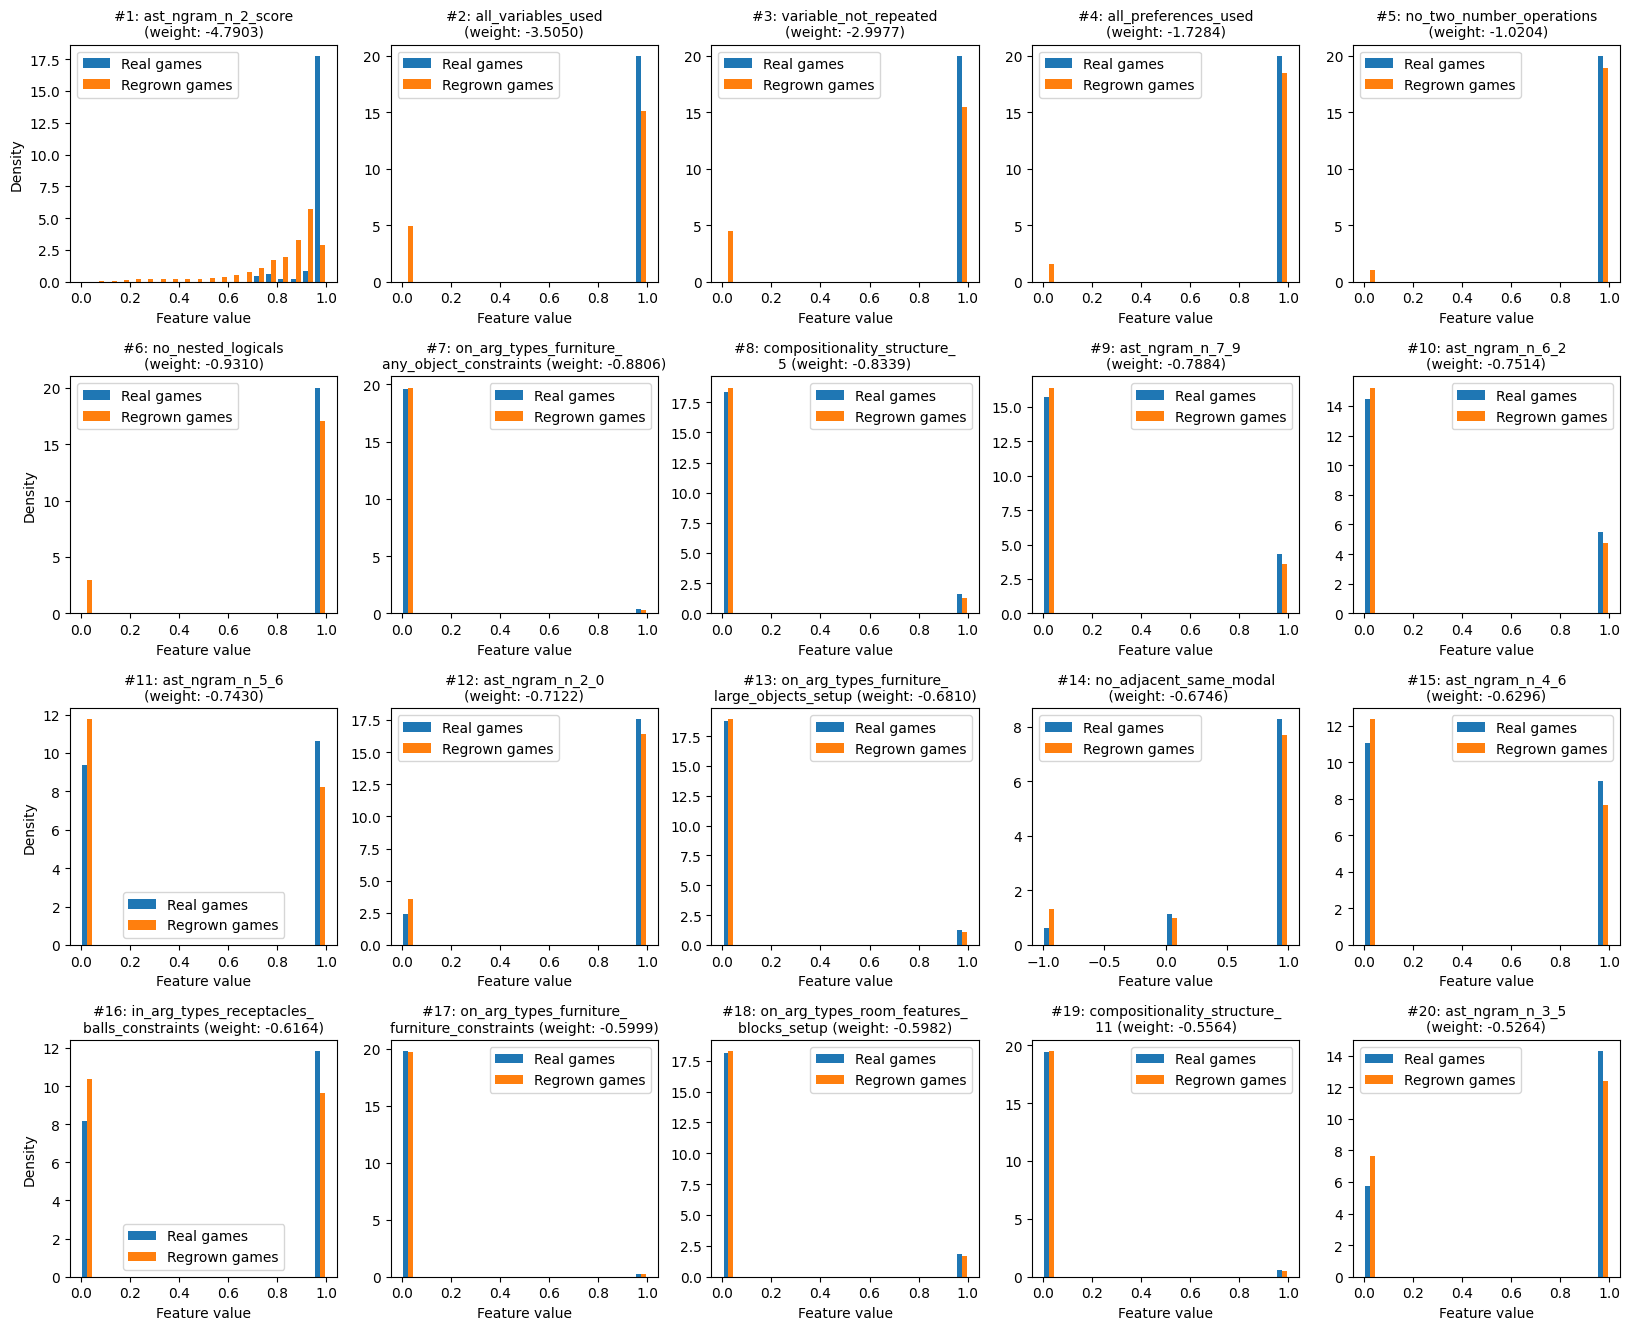

In [17]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

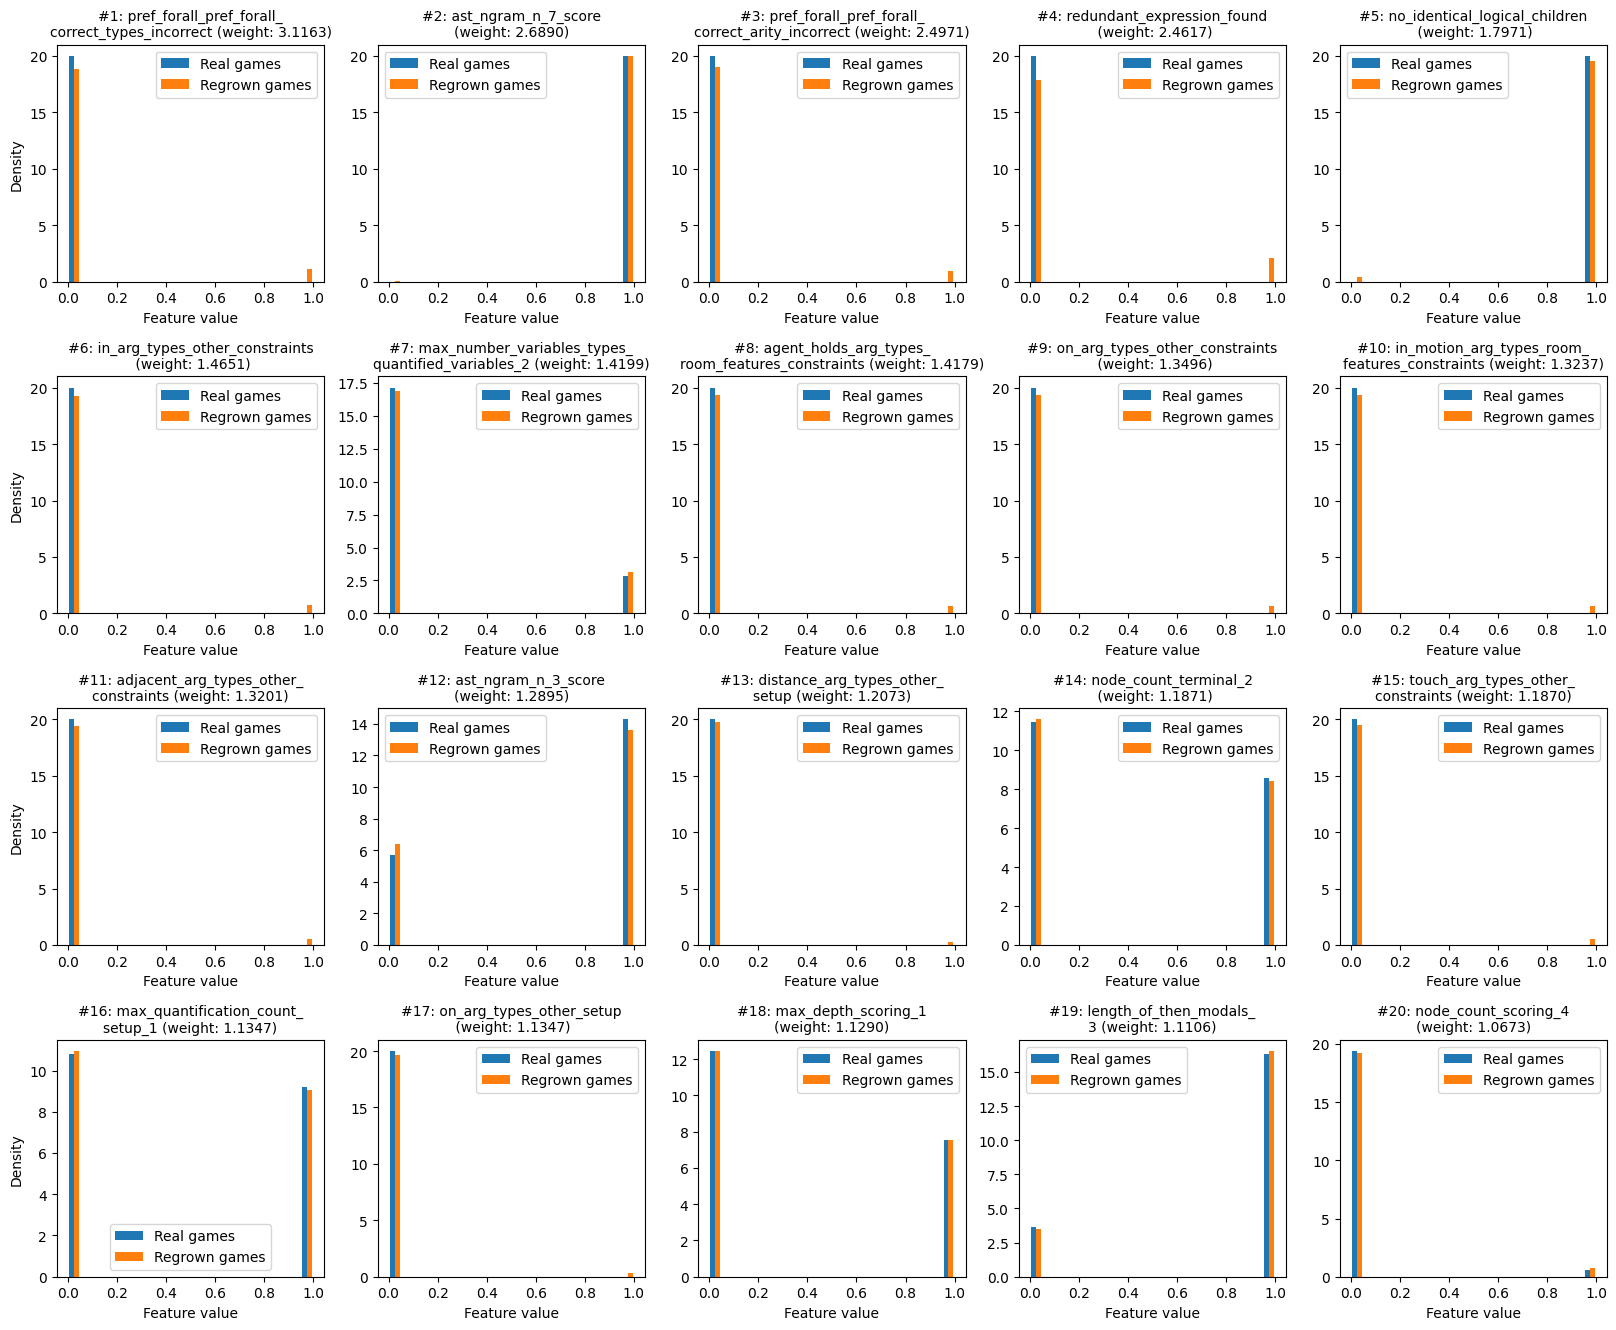

In [18]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [30]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [31]:
real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}')

Real game scores: 3.0752 ± 0.6222


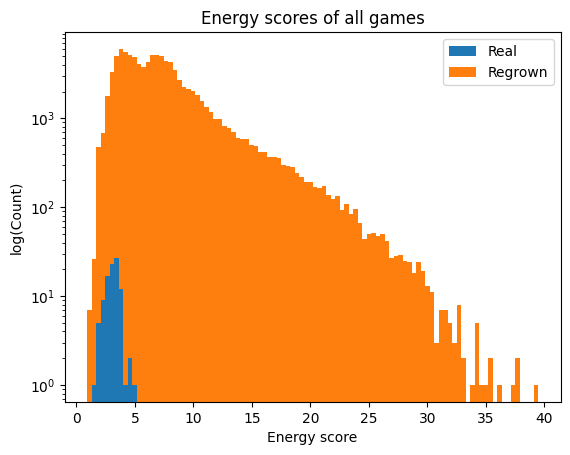

In [32]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [33]:
negatives_scores = full_tensor_scores[:, 1:]

In [34]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [35]:
torch.topk(score_diffs.ravel(), 10, largest=False)

torch.return_types.topk(
values=tensor([-2.6616, -2.4162, -2.2464, -2.0614, -2.0531, -2.0401, -1.9431, -1.8818,
        -1.6991, -1.5902]),
indices=tensor([39225, 53569, 53923, 53289, 88595, 63738, 53267, 89345, 25572, 66939]))

In [55]:
N_NEGATIVES = 10
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False)
    
    display(Markdown('---'))

Original game index: 38 | Negative game row: 38 | Negative game col: 313


### Energy of real game: 3.958 | Energy of regrown game: 1.297 | Difference: -2.662

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                       | Features decreasing energy (= more real)                |
|--------------------------------------------------------------------------------|---------------------------------------------------------|
| ast_ngram_n_4_6: **0.371** = (0.000 => 1.000) * 0.371                          | ast_ngram_n_6_1: **-0.743** = (0.000 => 1.000) * -0.743 |
| compositionality_structure_7: **0.340** = (1.000 => 0.000) * -0.340            | ast_ngram_n_5_1: **-0.630** = (0.000 => 1.000) * -0.630 |
| touch_arg_types_balls_ramps_constraints: **0.290** = (1.000 => 0.000) * -0.290 | ast_ngram_n_7_6: **-0.513** = (0.000 => 1.000) * -0.513 |
| ast_ngram_n_7_7: **0.278** = (0.000 => 1.000) * 0.278                          | ast_ngram_n_5_3: **-0.500** = (0.000 => 1.000) * -0.500 |
| ast_ngram_n_6_9: **0.165** = (0.000 => 1.000) * 0.165                          | ast_ngram_n_6_8: **-0.476** = (0.000 => 1.000) * -0.476 |
| ast_ngram_n_3_9: **0.131** = (0.000 => 1.000) * 0.131                          | ast_ngram_n_7_5: **-0.468** = (0.000 => 1.000) * -0.468 |
| ast_ngram_n_5_6: **0.056** = (0.000 => 1.000) * 0.056                          | ast_ngram_n_4_3: **-0.383** = (0.000 => 1.000) * -0.383 |
| ast_ngram_n_7_score: **0.055** = (0.981 => 0.969) * -4.790                     | ast_ngram_n_4_4: **-0.319** = (0.000 => 1.000) * -0.319 |
| ast_ngram_n_6_3: **0.003** = (0.000 => 1.000) * 0.003                          | ast_ngram_n_3_7: **-0.305** = (0.000 => 1.000) * -0.305 |
|                                                                                | ast_ngram_n_7_8: **-0.012** = (0.000 => 1.000) * -0.012 |

### Game Diffs

n,1,(define (game 5d470786da637a00014ba26f-47) (:domain many-objects-room-v1),n,1,(define (game 5d470786da637a00014ba26f-47-313-nd-12-rd3) (:domain many-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(forall (?c - color),,4,(forall (?c - color)
,5,(and,,5,(and
,6,(preference beachballBouncedOffRamp,,6,(preference beachballBouncedOffRamp
,7,(exists (?b - beachball ?r - green_triangular_ramp),,7,(exists (?b - beachball ?r - green_triangular_ramp)
,8,(then,,8,(then
,9,(once (and (agent_holds ?b) (not (on rug agent) ) (faces agent ?r) ) ),,9,(once (and (agent_holds ?b) (not (on rug agent) ) (faces agent ?r) ) )
t,10,(hold-while (and (in_motion ?b) (not (agent_holds ?b) ) ) (touch ?b ?r) ),t,10,(hold-while (and (in_motion ?b) (not (agent_holds ?b) ) ) (in_motion ?b) )
,11,(once (and (not (in_motion ?b) ) (on rug ?b) (rug_color_under ?b ?c) ) ),,11,(once (and (not (in_motion ?b) ) (on rug ?b) (rug_color_under ?b ?c) ) )


---

Original game index: 52 | Negative game row: 52 | Negative game col: 321


### Energy of real game: 4.109 | Energy of regrown game: 1.693 | Difference: -2.416

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                              | Features decreasing energy (= more real)                                             |
|---------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| on_arg_types_furniture_furniture_constraints: **0.600** = (1.000 => 0.000) * -0.600   | in_motion_arg_types_receptacles_constraints: **-1.052** = (1.000 => 0.000) * 1.052   |
| on_arg_types_furniture_receptacles_constraints: **0.399** = (1.000 => 0.000) * -0.399 | agent_holds_arg_types_furniture_constraints: **-0.902** = (1.000 => 0.000) * 0.902   |
|                                                                                       | agent_holds_arg_types_receptacles_constraints: **-0.619** = (1.000 => 0.000) * 0.619 |
|                                                                                       | in_motion_arg_types_furniture_constraints: **-0.504** = (1.000 => 0.000) * 0.504     |
|                                                                                       | ast_ngram_n_7_score: **-0.337** = (0.820 => 0.890) * -4.790                          |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-321-nd-8-rd3) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - teddy_bear)
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent agent desk) ) ),,7,(once (and (agent_holds ?o) (adjacent agent desk) ) )
,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) ),,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) )
,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) ),,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) )
,10,),,10,)
,11,),,11,)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 675


### Energy of real game: 4.109 | Energy of regrown game: 1.863 | Difference: -2.246

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                               | Features decreasing energy (= more real)                                              |
|----------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| on_arg_types_furniture_furniture_constraints: **0.600** = (1.000 => 0.000) * -0.600    | in_motion_arg_types_receptacles_constraints: **-1.052** = (1.000 => 0.000) * 1.052    |
| on_arg_types_furniture_receptacles_constraints: **0.399** = (1.000 => 0.000) * -0.399  | agent_holds_arg_types_furniture_constraints: **-0.902** = (1.000 => 0.000) * 0.902    |
| ast_ngram_n_7_score: **0.165** = (0.820 => 0.785) * -4.790                             | agent_holds_arg_types_receptacles_constraints: **-0.619** = (1.000 => 0.000) * 0.619  |
| on_arg_types_furniture_small_objects_constraints: **0.137** = (0.000 => 1.000) * 0.137 | in_motion_arg_types_small_objects_constraints: **-0.513** = (0.000 => 1.000) * -0.513 |
| agent_holds_arg_types_small_objects_constraints: **0.044** = (0.000 => 1.000) * 0.044  | in_motion_arg_types_furniture_constraints: **-0.504** = (1.000 => 0.000) * 0.504      |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-675-nd-9-rd2) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - (either book cd))
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent agent desk) ) ),,7,(once (and (agent_holds ?o) (adjacent agent desk) ) )
,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) ),,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) )
,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) ),,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) )
,10,),,10,)
,11,),,11,)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 41


### Energy of real game: 4.109 | Energy of regrown game: 2.048 | Difference: -2.061

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                | Features decreasing energy (= more real)                                             |
|-----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| ast_ngram_n_2_0: **1.289** = (0.000 => 1.000) * 1.289                                   | in_motion_arg_types_receptacles_constraints: **-1.052** = (1.000 => 0.000) * 1.052   |
| ast_ngram_n_2_1: **1.033** = (0.000 => 1.000) * 1.033                                   | agent_holds_arg_types_furniture_constraints: **-0.902** = (1.000 => 0.000) * 0.902   |
| agent_holds_arg_types_balls_constraints: **0.751** = (0.000 => 1.000) * 0.751           | ast_ngram_n_6_1: **-0.743** = (0.000 => 1.000) * -0.743                              |
| on_arg_types_furniture_furniture_constraints: **0.600** = (1.000 => 0.000) * -0.600     | ast_ngram_n_5_1: **-0.630** = (0.000 => 1.000) * -0.630                              |
| on_arg_types_furniture_receptacles_constraints: **0.399** = (1.000 => 0.000) * -0.399   | agent_holds_arg_types_receptacles_constraints: **-0.619** = (1.000 => 0.000) * 0.619 |
| in_motion_arg_types_balls_constraints: **0.394** = (0.000 => 1.000) * 0.394             | ast_ngram_n_7_score: **-0.536** = (0.820 => 0.932) * -4.790                          |
| on_arg_types_furniture_large_objects_constraints: **0.380** = (1.000 => 0.000) * -0.380 | ast_ngram_n_7_6: **-0.513** = (0.000 => 1.000) * -0.513                              |
| ast_ngram_n_4_6: **0.371** = (0.000 => 1.000) * 0.371                                   | ast_ngram_n_3_0: **-0.512** = (0.000 => 1.000) * -0.512                              |
| in_motion_arg_types_large_objects_constraints: **0.357** = (1.000 => 0.000) * -0.357    | in_motion_arg_types_furniture_constraints: **-0.504** = (1.000 => 0.000) * 0.504     |
| ast_ngram_n_7_1: **0.326** = (0.000 => 1.000) * 0.326                                   | ast_ngram_n_5_3: **-0.500** = (0.000 => 1.000) * -0.500                              |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-41-nd-8-rd3) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - dodgeball)
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent agent desk) ) ),,7,(once (and (agent_holds ?o) (adjacent agent desk) ) )
,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) ),,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) )
,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) ),,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) )
,10,),,10,)
,11,),,11,)


---

Original game index: 86 | Negative game row: 86 | Negative game col: 531


### Energy of real game: 4.750 | Energy of regrown game: 2.696 | Difference: -2.053

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                          | Features decreasing energy (= more real)                                       |
|-----------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| ast_ngram_n_7_score: **2.245** = (0.972 => 0.504) * -4.790                        | ast_ngram_n_2_4: **-2.689** = (1.000 => 0.000) * 2.689                         |
| all_preferences_used: **1.728** = (1.000 => 0.000) * -1.728                       | ast_ngram_n_2_0: **-1.289** = (1.000 => 0.000) * 1.289                         |
| ast_ngram_n_7_9: **0.788** = (1.000 => 0.000) * -0.788                            | length_of_then_modals_3: **-1.111** = (1.000 => 0.000) * 1.111                 |
| ast_ngram_n_6_7: **0.751** = (1.000 => 0.000) * -0.751                            | ast_ngram_n_2_1: **-1.033** = (1.000 => 0.000) * 1.033                         |
| node_count_constraints_0: **0.729** = (0.000 => 1.000) * 0.729                    | max_quantification_count_constraints_1: **-0.940** = (1.000 => 0.000) * 0.940  |
| ast_ngram_n_2_5: **0.712** = (1.000 => 0.000) * -0.712                            | mean_depth_constraints_2: **-0.899** = (1.000 => 0.000) * 0.899                |
| no_adjacent_same_modal: **0.675** = (1.000 => 0.000) * -0.675                     | agent_holds_arg_types_balls_constraints: **-0.751** = (1.000 => 0.000) * 0.751 |
| in_arg_types_receptacles_balls_constraints: **0.616** = (1.000 => 0.000) * -0.616 | ast_ngram_n_2_2: **-0.723** = (1.000 => 0.000) * 0.723                         |
| mean_depth_constraints_0: **0.612** = (0.000 => 1.000) * 0.612                    | node_count_constraints_1: **-0.568** = (1.000 => 0.000) * 0.568                |
| ast_ngram_n_3_0: **0.512** = (1.000 => 0.000) * -0.512                            | ast_ngram_n_2_6: **-0.527** = (1.000 => 0.000) * 0.527                         |

### Game Diffs

n,1,(define (game 6106ac34408681f3b0d07396-104) (:domain few-objects-room-v1),n,1,(define (game 6106ac34408681f3b0d07396-104-531-nd-3-rd16) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(equal_x_position ?h east_sliding_door),,7,(equal_x_position ?h east_sliding_door)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,),,11,)


---

Original game index: 62 | Negative game row: 62 | Negative game col: 250


### Energy of real game: 3.362 | Energy of regrown game: 1.322 | Difference: -2.040

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                          | Features decreasing energy (= more real)                                       |
|-----------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| all_preferences_used: **1.728** = (1.000 => 0.000) * -1.728                       | ast_ngram_n_2_4: **-2.689** = (1.000 => 0.000) * 2.689                         |
| ast_ngram_n_7_score: **0.834** = (0.979 => 0.805) * -4.790                        | ast_ngram_n_2_0: **-1.289** = (1.000 => 0.000) * 1.289                         |
| ast_ngram_n_7_9: **0.788** = (1.000 => 0.000) * -0.788                            | length_of_then_modals_3: **-1.111** = (1.000 => 0.000) * 1.111                 |
| ast_ngram_n_6_7: **0.751** = (1.000 => 0.000) * -0.751                            | ast_ngram_n_2_1: **-1.033** = (1.000 => 0.000) * 1.033                         |
| ast_ngram_n_6_1: **0.743** = (1.000 => 0.000) * -0.743                            | max_quantification_count_constraints_1: **-0.940** = (1.000 => 0.000) * 0.940  |
| node_count_constraints_0: **0.729** = (0.000 => 1.000) * 0.729                    | mean_depth_constraints_2: **-0.899** = (1.000 => 0.000) * 0.899                |
| ast_ngram_n_2_5: **0.712** = (1.000 => 0.000) * -0.712                            | agent_holds_arg_types_balls_constraints: **-0.751** = (1.000 => 0.000) * 0.751 |
| no_adjacent_same_modal: **0.675** = (1.000 => 0.000) * -0.675                     | ast_ngram_n_2_2: **-0.723** = (1.000 => 0.000) * 0.723                         |
| in_arg_types_receptacles_balls_constraints: **0.616** = (1.000 => 0.000) * -0.616 | ast_ngram_n_2_3: **-0.638** = (1.000 => 0.000) * 0.638                         |
| mean_depth_constraints_0: **0.612** = (0.000 => 1.000) * 0.612                    | ast_ngram_n_6_4: **-0.581** = (1.000 => 0.000) * 0.581                         |

### Game Diffs

n,1,(define (game 60ef5b1cf52939a80af77543-73) (:domain many-objects-room-v1),n,1,(define (game 60ef5b1cf52939a80af77543-73-250-nd-3-rd16) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance ?h room_center) 1),,6,(< (distance ?h room_center) 1)
,7,),,7,)
,8,),,8,)
,9,(forall (?d - dodgeball),,9,(forall (?d - dodgeball)
,10,(game-optional,,10,(game-optional
,11,(on desk ?d),,11,(on desk ?d)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 19


### Energy of real game: 4.109 | Energy of regrown game: 2.166 | Difference: -1.943

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                              | Features decreasing energy (= more real)                                             |
|---------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| on_arg_types_furniture_furniture_constraints: **0.600** = (1.000 => 0.000) * -0.600   | in_motion_arg_types_receptacles_constraints: **-1.052** = (1.000 => 0.000) * 1.052   |
| on_arg_types_furniture_receptacles_constraints: **0.399** = (1.000 => 0.000) * -0.399 | agent_holds_arg_types_furniture_constraints: **-0.902** = (1.000 => 0.000) * 0.902   |
| ast_ngram_n_7_score: **0.136** = (0.820 => 0.791) * -4.790                            | agent_holds_arg_types_receptacles_constraints: **-0.619** = (1.000 => 0.000) * 0.619 |
|                                                                                       | in_motion_arg_types_furniture_constraints: **-0.504** = (1.000 => 0.000) * 0.504     |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-19-nd-9-rd2) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - (either game_object laptop))
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent agent desk) ) ),,7,(once (and (agent_holds ?o) (adjacent agent desk) ) )
,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) ),,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) )
,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) ),,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) )
,10,),,10,)
,11,),,11,)


---

Original game index: 87 | Negative game row: 87 | Negative game col: 257


### Energy of real game: 3.643 | Energy of regrown game: 1.761 | Difference: -1.882

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                               | Features decreasing energy (= more real)                                             |
|----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| max_quantification_count_constraints_1: **0.940** = (0.000 => 1.000) * 0.940           | max_quantification_count_constraints_2: **-0.989** = (1.000 => 0.000) * 0.989        |
| node_count_constraints_0: **0.729** = (0.000 => 1.000) * 0.729                         | max_depth_constraints_3: **-0.798** = (1.000 => 0.000) * 0.798                       |
| ast_ngram_n_7_score: **0.686** = (0.992 => 0.849) * -4.790                             | node_count_constraints_2: **-0.761** = (1.000 => 0.000) * 0.761                      |
| mean_depth_constraints_0: **0.612** = (0.000 => 1.000) * 0.612                         | ast_ngram_n_2_2: **-0.723** = (1.000 => 0.000) * 0.723                               |
| length_of_then_modals_4: **0.385** = (1.000 => 0.000) * -0.385                         | no_adjacent_same_modal: **-0.675** = (-1.000 => 0.000) * -0.675                      |
| distance_arg_types_furniture_blocks_constraints: **0.190** = (1.000 => 0.000) * -0.190 | ast_ngram_n_2_3: **-0.638** = (1.000 => 0.000) * 0.638                               |
| length_of_then_modals_1: **0.117** = (0.000 => 1.000) * 0.117                          | ast_ngram_n_2_6: **-0.527** = (1.000 => 0.000) * 0.527                               |
| setup_objects_used: **0.087** = (0.250 => 0.000) * -0.346                              | in_motion_arg_types_blocks_constraints: **-0.289** = (1.000 => 0.000) * 0.289        |
| distance_arg_types_blocks_blocks_constraints: **0.075** = (1.000 => 0.000) * -0.075    | mean_depth_constraints_4: **-0.157** = (1.000 => 0.000) * 0.157                      |
| max_depth_constraints_0: **0.054** = (0.000 => 1.000) * 0.054                          | on_arg_types_room_features_blocks_constraints: **-0.133** = (1.000 => 0.000) * 0.133 |

### Game Diffs

n,1,(define (game 61015f63f9a351d3171a0f98-105) (:domain few-objects-room-v1),n,1,(define (game 61015f63f9a351d3171a0f98-105-257-nd-5-rd22) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?c - chair),,4,(forall (?c - chair)
,5,(game-conserved,,5,(game-conserved
,6,(or,,6,(or
,7,(on bed ?c),,7,(on bed ?c)
,8,(adjacent bed ?c),,8,(adjacent bed ?c)
,9,),,9,)
,10,),,10,)
,11,),,11,)


---

Original game index: 24 | Negative game row: 24 | Negative game col: 996


### Energy of real game: 3.179 | Energy of regrown game: 1.480 | Difference: -1.699

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                | Features decreasing energy (= more real)                                             |
|-----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| node_count_constraints_0: **0.729** = (0.000 => 1.000) * 0.729                          | max_depth_constraints_2: **-1.009** = (1.000 => 0.000) * 1.009                       |
| ast_ngram_n_2_5: **0.712** = (1.000 => 0.000) * -0.712                                  | agent_holds_arg_types_balls_constraints: **-0.751** = (1.000 => 0.000) * 0.751       |
| in_arg_types_receptacles_balls_constraints: **0.616** = (1.000 => 0.000) * -0.616       | ast_ngram_n_2_2: **-0.723** = (1.000 => 0.000) * 0.723                               |
| mean_depth_constraints_0: **0.612** = (0.000 => 1.000) * 0.612                          | no_adjacent_same_modal: **-0.675** = (-1.000 => 0.000) * -0.675                      |
| ast_ngram_n_4_0: **0.526** = (1.000 => 0.000) * -0.526                                  | ast_ngram_n_2_3: **-0.638** = (1.000 => 0.000) * 0.638                               |
| in_motion_arg_types_small_objects_constraints: **0.513** = (1.000 => 0.000) * -0.513    | on_arg_types_furniture_furniture_constraints: **-0.600** = (0.000 => 1.000) * -0.600 |
| max_depth_constraints_1: **0.513** = (0.000 => 1.000) * 0.513                           | node_count_constraints_1: **-0.568** = (1.000 => 0.000) * 0.568                      |
| length_of_then_modals_4: **0.385** = (1.000 => 0.000) * -0.385                          | ast_ngram_n_2_6: **-0.527** = (1.000 => 0.000) * 0.527                               |
| on_arg_types_furniture_large_objects_constraints: **0.380** = (1.000 => 0.000) * -0.380 | ast_ngram_n_3_3: **-0.497** = (1.000 => 0.000) * 0.497                               |
| in_motion_arg_types_large_objects_constraints: **0.357** = (1.000 => 0.000) * -0.357    | in_motion_arg_types_balls_constraints: **-0.394** = (1.000 => 0.000) * 0.394         |

### Game Diffs

n,1,(define (game 5b8c8e7d0c740e00019d55c3-31) (:domain few-objects-room-v1),n,1,(define (game 5b8c8e7d0c740e00019d55c3-31-996-nd-6-rd15) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(adjacent desk ?h),,7,(adjacent desk ?h)
,8,(forall (?b - cube_block),,8,(forall (?b - cube_block)
,9,(adjacent ?h ?b),,9,(adjacent ?h ?b)
,10,),,10,)
,11,),,11,)


---

Original game index: 65 | Negative game row: 65 | Negative game col: 379


### Energy of real game: 2.868 | Energy of regrown game: 1.278 | Difference: -1.590

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                             | Features decreasing energy (= more real)                                        |
|----------------------------------------------------------------------|---------------------------------------------------------------------------------|
| ast_ngram_n_7_score: **0.077** = (0.976 => 0.960) * -4.790           | ast_ngram_n_5_1: **-0.630** = (0.000 => 1.000) * -0.630                         |
| compositionality_structure_10: **0.005** = (1.000 => 0.000) * -0.005 | ast_ngram_n_4_3: **-0.383** = (0.000 => 1.000) * -0.383                         |
|                                                                      | ast_ngram_n_4_4: **-0.319** = (0.000 => 1.000) * -0.319                         |
|                                                                      | ast_ngram_n_3_7: **-0.305** = (0.000 => 1.000) * -0.305                         |
|                                                                      | touch_arg_types_balls_blocks_constraints: **-0.036** = (1.000 => 0.000) * 0.036 |

### Game Diffs

n,1,(define (game 5d0ba121619661001a7f4fe6-76) (:domain few-objects-room-v1),n,1,(define (game 5d0ba121619661001a7f4fe6-76-379-nd-10-rd3) (:domain few-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(forall (?c - (either pink yellow)),,4,(forall (?c - (either pink yellow))
,5,(and,,5,(and
,6,(preference blockToBinFromRug,,6,(preference blockToBinFromRug
,7,(exists (?b - cube_block ?h - hexagonal_bin),,7,(exists (?b - cube_block ?h - hexagonal_bin)
,8,(then,,8,(then
,9,(once (and (agent_holds ?b) (rug_color_under agent ?c) ) ),,9,(once (and (agent_holds ?b) (rug_color_under agent ?c) ) )
,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) ),,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )
,11,(once (and (not (in_motion ?b) ) (or (in ?h ?b) (exists (?bl - building) (and (in ?bl,,11,(once (and (not (in_motion ?b) ) (or (in ?h ?b) (exists (?bl - building) (and (in ?bl


---

In [43]:
cv_energy_model['wrapper']

## Weird n-gram features

In [32]:
threshold = 0.98
gb = data_df.groupby('real').mean(numeric_only=True)
for c in gb.columns:
    if (gb[c] > threshold).all():
        print(f'Feature {c} is (almost) always 1: {gb[c].to_dict()}')

Feature no_identical_logical_children is (almost) always 1: {0: 0.9817442602040817, 1: 1.0}
Feature ast_ngram_n_2_4 is (almost) always 1: {0: 0.9989636479591837, 1: 1.0}
Feature ast_ngram_n_2_5 is (almost) always 1: {0: 0.9989636479591837, 1: 1.0}
Feature ast_ngram_n_3_0 is (almost) always 1: {0: 0.9989636479591837, 1: 1.0}


In [59]:
data_df.groupby('real')[[c for c in data_df.columns if 'quantification' in c]].mean(numeric_only=True)

,max_quantification_count_setup_0,max_quantification_count_setup_1,max_quantification_count_setup_2,max_quantification_count_setup_3,max_quantification_count_setup_4,max_quantification_count_setup_5,max_quantification_count_constraints_0,max_quantification_count_constraints_1,max_quantification_count_constraints_2,max_quantification_count_constraints_3,max_quantification_count_constraints_4,max_quantification_count_constraints_5
real,,,,,,,,,,,,
0,0.408323,0.453444,0.121811,0.013951,0.001116,0.001355,0.0,0.614955,0.333705,0.050143,0.000957,0.000239
1,0.408163,0.459184,0.122449,0.010204,0.000000,0.000000,0.0,0.632653,0.326531,0.040816,0.000000,0.000000


In [80]:
np.exp(-2)

0.13533528323661267

In [57]:
N = 30
minimal_tensor = full_tensor[50, [0, 36], :].unsqueeze(0)

model = copy.deepcopy(cv_energy_model.named_steps['fitness'].model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for i in range(N):
    optimizer.zero_grad()
    scores = model(minimal_tensor)
    loss = utils.fitness_square_square_loss(scores, margin=4)
    print(i, scores.detach().squeeze().numpy(), loss.item())
    loss.backward()
    optimizer.step()


0 [ 0.37131846 -3.2521784 ] 52.73196792602539
1 [5.0262613 2.5184705] 27.458232879638672
2 [-3.127551    0.05366278] 25.355154037475586
3 [5.529273  5.6445255] 30.572860717773438
4 [-4.640136   1.5747781] 27.412559509277344
5 [5.679028 7.011265] 32.25135803222656
6 [-4.7658095  2.8312907] 24.078821182250977
7 [4.8596544 7.3131027] 23.616241455078125
8 [-4.078195  3.736218] 16.701255798339844
9 [3.6165524 6.957756 ] 13.079450607299805
10 [-3.034992  4.29584 ] 9.211175918579102
11 [2.546949 6.529706] 6.4869489669799805
12 [-2.1373851  4.655057 ] 4.56841516494751
13 [1.7936817 6.228251 ] 3.217294216156006
14 [-1.5052478  4.9080353] 2.2657711505889893
15 [1.2631954 6.0159526] 1.5956625938415527
16 [-1.0600672  5.086194 ] 1.1237424612045288
17 [0.88960326 5.8664427 ] 0.7913939356803894
18 [-0.7465491  5.2116632] 0.557335615158081
19 [0.6264994 5.7611504] 0.39250150322914124
20 [-0.5257547  5.3000236] 0.276418000459671
21 [0.4412099 5.686999 ] 0.19466619193553925
22 [-0.37026    5.3622518] 0

In [ ]:
from src.fitness_features import *
with gzip.open('../models/fitness_featurizer_2023_02_14.pkl.gz', 'rb') as f:
    featurizer = pickle.load(f)  # type: ignore

In [54]:
_ = featurizer.parse(game_asts[0], '', True)

In [56]:
featurizer.full_ast_registry[0].n_gram_model.model.top_k_ngrams

{2: [(('predicate_agent_holds', 'balls'), 231),
  (('predicate_in_motion', 'balls'), 219),
  (('once', 'super_predicate_and'), 202),
  (('super_predicate_and', 'super_predicate_not'), 194),
  (('preference', 'pref_body_exists'), 179),
  (('pref_body_exists', 'variable_list'), 179),
  (('super_predicate_not', 'predicate_agent_holds'), 165),
  (('then', 'once'), 155),
  (('super_predicate_not', 'predicate_in_motion'), 141),
  (('hold', 'super_predicate_and'), 122)],
 3: [(('preference', 'pref_body_exists', 'variable_list'), 179),
  (('super_predicate_not', 'predicate_agent_holds', 'balls'), 116),
  (('super_predicate_not', 'predicate_in_motion', 'balls'), 103),
  (('then', 'once', 'super_predicate_and'), 98),
  (('once', 'super_predicate_and', 'super_predicate_not'), 97),
  (('super_predicate_and', 'super_predicate_not', 'predicate_in_motion'), 97),
  (('function_comparison', 'two_arg_comparison', 'comparison_arg'), 96),
  (('two_arg_comparison', 'comparison_arg', 'function_distance'), 8

In [45]:
data_df.game_name[data_df.ast_ngram_n_2_4 == 0]

373        614b603d4da88384282967a7-3-19-nd3-rd10
374         614b603d4da88384282967a7-3-20-nd5-rd8
458        614b603d4da88384282967a7-3-104-nd6-rd7
471       614b603d4da88384282967a7-3-117-nd3-rd10
3500      614e1599db14d8f3a5c1486a-33-74-nd2-rd14
5710     602d84f17cdd707e9caed37a-52-108-nd2-rd22
5908      61541833a06877a656163b10-54-50-nd6-rd15
5914      61541833a06877a656163b10-54-56-nd3-rd18
6533      602a1735bf92e79a5e7cb632-59-35-nd6-rd15
7103      5aeb24e22bd17300018779f2-64-93-nd6-rd15
8653     616da508e4014f74f43c8433-77-107-nd2-rd17
9914      6103ec2bf88328284fd894bc-89-88-nd4-rd17
10774    5c7ceda01d2afc0001f4ad1d-100-52-nd6-rd16
Name: game_name, dtype: object

In [76]:
data_df.columns[(data_df == 0).sum() < 300]

Index(['src_file', 'game_name', 'domain_name', 'original_game_name',
       'no_identical_logical_children', 'ast_ngram_score', 'ast_ngram_n_2_4',
       'ast_ngram_n_2_5', 'ast_ngram_n_3_0'],
      dtype='object')

In [77]:
(data_df == 0).sum().sort_values(ascending=True).head(50)

src_file                                         0
game_name                                        0
domain_name                                      0
original_game_name                               0
ast_ngram_score                                  1
ast_ngram_n_2_5                                 13
ast_ngram_n_2_4                                 13
ast_ngram_n_3_0                                 13
no_identical_logical_children                  229
no_two_number_operations                       559
all_preferences_used                           880
all_variables_defined                          890
no_adjacent_same_modal                        1318
no_nested_logicals                            1584
ast_ngram_n_2_7                               1624
starts_and_ends_once                          1932
ast_ngram_n_2_2                               2068
ast_ngram_n_2_3                               2146
ast_ngram_n_2_6                               2197
length_of_then_modals_3        

In [9]:
data_df.groupby('real').section_without_pref_or_total_count_scoring.sum() / len(data_df)

real
0    0.001643
1    0.000000
Name: section_without_pref_or_total_count_scoring, dtype: float64

In [10]:
data_df.groupby('section_without_pref_or_total_count_scoring')['all_preferences_used'].mean()

section_without_pref_or_total_count_scoring
0    0.924495
1    0.054545
Name: all_preferences_used, dtype: float64